In [ ]:
!nvidia-smi

Tue Aug  1 06:52:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os

In [ ]:
os.environ["KAGGLE_CONFIG_DIR"] = '/content/'

In [ ]:
!kaggle datasets download -d kshitij192/cars-image-dataset

 91% 33.0M/36.3M [00:01<00:00, 24.5MB/s]
100% 36.3M/36.3M [00:01<00:00, 20.7MB/s]


In [ ]:
!unzip '*.zip' && rm *.zip


Archive:  cars-image-dataset.zip
  inflating: Cars Dataset/test/Audi/1000.jpg  
  inflating: Cars Dataset/test/Audi/1003.jpg  
  inflating: Cars Dataset/test/Audi/1008.jpg  
  inflating: Cars Dataset/test/Audi/1020.jpg  
  inflating: Cars Dataset/test/Audi/1022.jpg  
  inflating: Cars Dataset/test/Audi/1025.jpg  
  inflating: Cars Dataset/test/Audi/1027.jpg  
  inflating: Cars Dataset/test/Audi/1038.jpg  
  inflating: Cars Dataset/test/Audi/104.jpg  
  inflating: Cars Dataset/test/Audi/1043.jpg  
  inflating: Cars Dataset/test/Audi/1051.jpg  
  inflating: Cars Dataset/test/Audi/1059.jpg  
  inflating: Cars Dataset/test/Audi/1060.jpg  
  inflating: Cars Dataset/test/Audi/1064.jpg  
  inflating: Cars Dataset/test/Audi/1066.jpg  
  inflating: Cars Dataset/test/Audi/1072.jpg  
  inflating: Cars Dataset/test/Audi/1073.jpg  
  inflating: Cars Dataset/test/Audi/1080.jpg  
  inflating: Cars Dataset/test/Audi/1084.jpg  
  inflating: Cars Dataset/test/Audi/1085.jpg  
  inflating: Cars Dataset/te

Load and Preprocess the Data:


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


train_dir = '/content/Cars Dataset/train'
test_dir = '/content/Cars Dataset/test'
img_height, img_width = 224, 224
batch_size = 32

In [ ]:
# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
 )

In [ ]:
# Load training data and split into training and validation sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'  # Use subset argument to specify 'training' split
)

Found 3352 images belonging to 7 classes.


In [ ]:
# No data augmentation for the test set, only rescaling
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 813 images belonging to 7 classes.


Calculate Class Weights:


In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:")
for class_label, weight in class_weights_dict.items():
    print(class_label, ":", weight)

Class Weights:
0 : 0.5882765882765882
1 : 1.7670005271481286
2 : 1.515370705244123
3 : 1.5397335783187873
4 : 1.1293800539083558
5 : 1.0858438613540655
6 : 0.6178801843317973


In [ ]:
class_names = list(train_generator.class_indices.keys())
class_indices = list(train_generator.class_indices.values())
class_counts = train_generator.classes
class_indices,class_names,class_counts


([0, 1, 2, 3, 4, 5, 6],
 ['Audi',
  'Hyundai Creta',
  'Mahindra Scorpio',
  'Rolls Royce',
  'Swift',
  'Tata Safari',
  'Toyota Innova'],
 array([0, 0, 0, ..., 6, 6, 6], dtype=int32))

In [ ]:
# Find the most and least represented classes
most_represented_class = class_names[np.argmax(np.bincount(class_counts))]
least_represented_class = class_names[np.argmin(np.bincount(class_counts))]

print("Most Represented Class:", most_represented_class)
print("Least Represented Class:", least_represented_class)

Most Represented Class: Audi
Least Represented Class: Hyundai Creta


CNN model

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# optimizer='adam',extension of the stochastic gradient descent (SGD)
# loss function is used for  multi-class classification problems with one-hot encoded labels

 The 'adam' optimizer will be used to minimize the categorical cross-entropy loss during training, aiming to improve the model's accuracy on the multi-class classification task.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [ ]:
# Train the model with class weights
car_model = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    epochs=50,
    class_weight=class_weights_dict
)

Epoch 1/50
104/104 [==============================] - 55s 407ms/step - loss: 1.9704 - accuracy: 0.2268 - val_loss: 1.8743 - val_accuracy: 0.1673
Epoch 2/50
104/104 [==============================] - 44s 423ms/step - loss: 1.8335 - accuracy: 0.2355 - val_loss: 1.8265 - val_accuracy: 0.2472
Epoch 3/50
104/104 [==============================] - 46s 438ms/step - loss: 1.8071 - accuracy: 0.2696 - val_loss: 1.7602 - val_accuracy: 0.2854
Epoch 4/50
104/104 [==============================] - 44s 425ms/step - loss: 1.7454 - accuracy: 0.2849 - val_loss: 1.6642 - val_accuracy: 0.3506
Epoch 5/50
104/104 [==============================] - 43s 413ms/step - loss: 1.7150 - accuracy: 0.3277 - val_loss: 1.6989 - val_accuracy: 0.3542
Epoch 6/50
104/104 [==============================] - 44s 426ms/step - loss: 1.6801 - accuracy: 0.3476 - val_loss: 1.6438 - val_accuracy: 0.3850
Epoch 7/50
104/104 [==============================] - 42s 407ms/step - loss: 1.6528 - accuracy: 0.3614 - val_loss: 1.5847 - val_ac

In [ ]:
model.save('/content/car_model_new.h5')

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, average_precision_score
import numpy as np

In [ ]:
y_pred = model.predict(test_generator)
y_true = test_generator.classes

26/26 [==============================] - 3s 100ms/step


In [ ]:
# Convert probabilities to class predictions
unique_classes, class_counts = np.unique(y_pred_classes, return_counts=True)

# Print the unique class indices and their counts
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: Count {count}")

Class 0: Count 189
Class 1: Count 63
Class 2: Count 130
Class 3: Count 103
Class 4: Count 87
Class 5: Count 105
Class 6: Count 136


In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred_classes)
# it takes the weighted average,
# where each class's contribution is proportional to the number of samples in that class.

In [ ]:
car_model.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
# Plot the confusion matrix (Optional)
import seaborn as sns
import matplotlib.pyplot as plt

Accuracy: 0.7810578105781057
Precision: 0.8194777922335442
Recall: 0.7810578105781057
F1-Score: 0.7880076610802541


In [ ]:
acc = car_model.history['accuracy']
val_acc = car_model.history['val_accuracy']

loss = car_model.history['loss']
val_loss = car_model.history['val_loss']

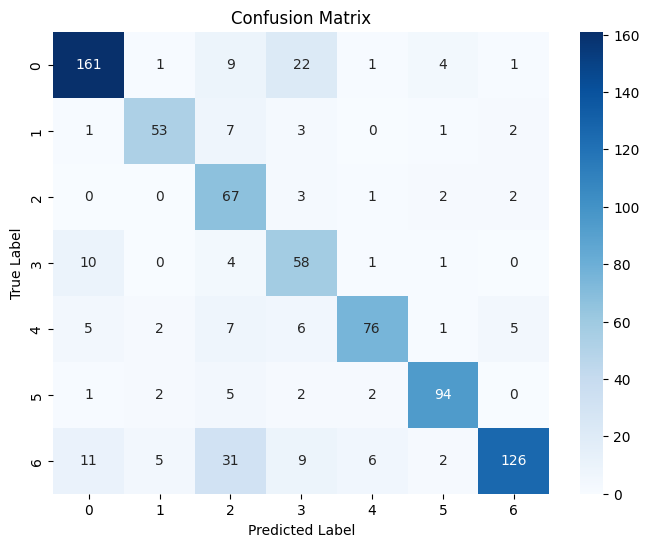

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

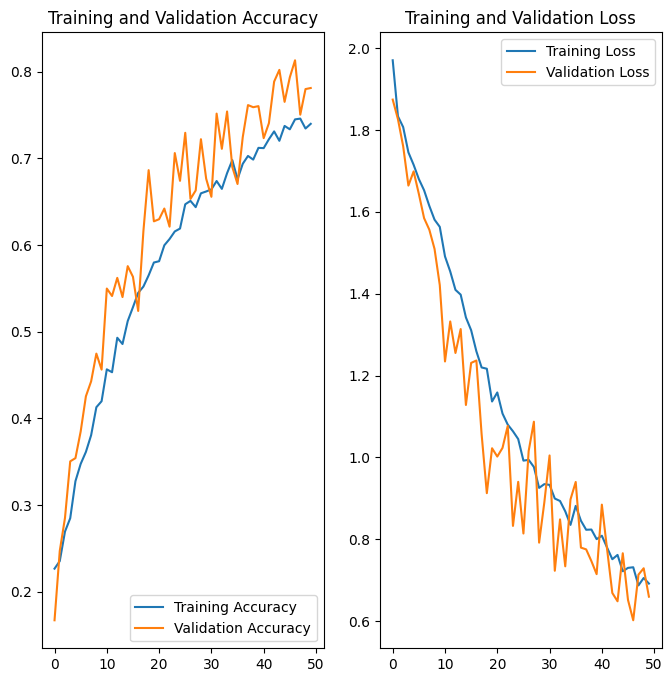

In [ ]:
import matplotlib.pyplot as plt
EPOCHS = 50

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

26/26 [==============================] - 1s 51ms/step - loss: 0.6598 - accuracy: 0.7811
Test Loss: 0.6597804427146912
Test Accuracy: 0.7810578346252441


In [ ]:
from sklearn.metrics import classification_report
y_true=test_generator.classes
predictions=model.predict(test_generator,  steps =813)
y_pred = np.argmax(predictions, axis=-1)
print(classification_report(y_true,y_pred))

 26/813 [..............................] - ETA: 36s

813/813 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       199
           1       0.84      0.79      0.82        67
           2       0.52      0.89      0.65        75
           3       0.56      0.78      0.66        74
           4       0.87      0.75      0.80       102
           5       0.90      0.89      0.89       106
           6       0.93      0.66      0.77       190

    accuracy                           0.78       813
   macro avg       0.78      0.80      0.77       813
weighted avg       0.82      0.78      0.79       813



In [ ]:
from keras.models import load_model

# Load the saved model
saved_model_path = '/content/car_model_new.h5'
loaded_model = load_model(saved_model_path)

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load and preprocess the new image
image_path = '/content/Cars Dataset/train/Audi/10.jpg'
img = load_img(image_path, target_size=(img_height, img_width))  # Assuming you have set img_height and img_width appropriately
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
preprocessed_image = preprocess_input(img_array)
# Make predictions

# Make predictions
predictions = loaded_model.predict(preprocessed_image)

# Convert predictions to class labels (assuming one-hot encoded predictions)
predicted_class_index = np.argmax(predictions[0])

1/1 [==============================] - 0s 18ms/step


In [ ]:
# Class mapping
class_mapping = {
    0: 'class_A',
    1: 'class_B',
    2: 'class_C',
    3: 'class_D',
    4: 'class_E',
    # Add more class mappings as needed
}

# Get predicted class name using class_mapping
predicted_class_name = class_mapping[predicted_class_index]
print("Predicted Class:", predicted_class_name)

Predicted Class: class_A


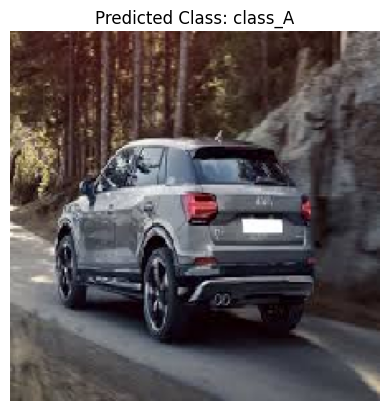

In [ ]:
# Get predicted class name using class_mapping
predicted_class_name = class_mapping.get(predicted_class_index, 'Unknown')

# Display the image
plt.imshow(img)
plt.title('Predicted Class: ' + predicted_class_name)
plt.axis('off')  # Remove axis ticks and labels
plt.show()